## Create Experiment

In [1]:
# Hyperparameters
SEED = 42
DIM = 384
EPOCHS = 16
NUM_CLASSES = 1
BATCH_SIZE = 256
VERBOSE_LEVEL = 1
SAVE_OUTPUT = True

LABEL_SMOOTHING = 0.05

# LR SCHEDULE 
LR_MAX = 1e-4
LR_MIN = 1e-7
LR_START = 1e-4

MODE = "triangular2"
STEP_SIZE = 4

# The 2019 Data may decrease the model performance. More Infos here: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/168028 
EXCLUDE_2019 = True

In [2]:
AUGMENTATION_CONFIG = {
    'ROT_': 180.0,
    'SHR_': 6,
    'HZOOM_': 10.0,
    'WZOOM_': 10.0,
    'HSHIFT_': 10.0,
    'WSHIFT_': 10.0,
    'CROP': 0.90,
    'PROBABILITY_DROPOUT': 0.75
}

In [3]:
%%capture
# Create an experiment comet_ml experiment
!pip install --upgrade comet_ml --quiet

In [4]:
import json
from comet_ml import Experiment

experiment = False
path_to_auth_file = '/content/drive/MyDrive/Colab Notebooks/_auth/comet.json'

In [5]:
with open(path_to_auth_file) as json_file:
    data = json.load(json_file)
    experiment = Experiment(
        api_key=data['api_key'],
        project_name=data['project_name'],
        workspace=data['workspace'],
        log_code=True,
        auto_histogram_tensorboard_logging=True,
        auto_histogram_weight_logging=True,
        auto_histogram_gradient_logging=True,
        auto_histogram_activation_logging=True,
    )
    experiment.add_tag('effnetB5 - Imagenet')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/saschamet/master-thesis/5f4da84d74c84b4bbc28ce5ce2804c2a



# Setup

In [6]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 3.0MB/s 


In [7]:
import os
import re
import sys
import glob
import json
import math
import shutil
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
import matplotlib.cm as cm
from functools import partial
from joblib import dump, load
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn
from datetime import datetime, date
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix

In [8]:
# cleanup
for f in glob.glob("/content/*.png"):
    os.remove(f)

for f in glob.glob("/content/*.hdf5"):
    os.remove(f)

for f in glob.glob("/content/*.txt"):
    os.remove(f)

for f in glob.glob("/content/*.h5"):
    os.remove(f)

for f in glob.glob("/content/*.json"):
    os.remove(f)

!rm -rf logs

In [9]:
%%capture
!rm -rf /content/melanoma-classification
!rm -rf /content/sample_data/

# if we do not have the data
if not os.path.exists("/content/melanoma-classification/README.md"):
    # install kaggle
    !pip install kaggle

    # get kaggle auth file
    path_to_auth_file = "kaggle.json"
    if not os.path.exists(path_to_auth_file):
        path_to_auth_file = '/content/drive/MyDrive/Colab Notebooks/_auth/kaggle.json'

    # read the kaggle.json file
    with open(path_to_auth_file) as json_file:
        data = json.load(json_file)
        os.environ['KAGGLE_USERNAME'] = data["username"]
        os.environ['KAGGLE_KEY'] = data["key"]

    # remove sample data so we have more space
    !rm -rf /content/sample_data

    ## pull repo
    !git clone https://github.com/SaschaMet/melanoma-classification.git

    ## update repo
    !cd melanoma-classification && git fetch && git pull

    ## switch branch and execute function
    !cd /content/melanoma-classification && git checkout "master" && git fetch && git reset --hard origin/master

In [10]:
# make sure the repo ist added to the sys path
sys.path.insert(0,'/content/melanoma-classification')
sys.path.insert(1,'/content/melanoma-classification/src')

In [11]:
# Tensorflow execution optimizations
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)
REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS:", REPLICAS)

INFO:tensorflow:Initializing the TPU system: grpc://10.109.198.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.109.198.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


In [12]:
# Set needed env variables based on the global variables
os.environ["DIM"] = str(DIM)
os.environ["BATCH_SIZE"] = str(BATCH_SIZE)

# seed everything
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

# environment settings
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.4.1


In [13]:
%load_ext autoreload
%autoreload 2

# Custom imports
from plots.plot_auc import plot_auc
from plots.plot_confusion_matrix import plot_confusion_matrix
from plots.display_batch_of_images import display_batch_of_images
from model.clr_callback import cyclic_learning_rate, get_lr_callback, plot_clr
from model.evaluation import evaluate_model, predict_on_dataset, pred_to_binary, calc_f1

In [14]:
## prevent colab shutdown 
%%javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

var connection = setInterval(ConnectButton, 60000);

function myStopFunction() {
    console.log("Remove interal"); 
    clearInterval(connection);
}

<IPython.core.display.Javascript object>

# Data Loading, Preparation & Augmentation

## Loading

In [22]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [23]:
df_train = pd.read_csv('/content/melanoma-classification/data/train.csv')
df_test = pd.read_csv('/content/melanoma-classification/data/test.csv')

In [24]:
# Datasets used: https://www.kaggle.com/cdeotte/melanoma-384x384 & https://www.kaggle.com/cdeotte/isic2019-384x384
GCS_PATH_2020 = 'gs://kds-579028ef101a06c274c0a74c3cd3a71501181e4147dfccd933d27ef8'
GCS_PATH_OLD = 'gs://kds-f4203383b0e299bd453b67a4e3fbeb232f2168c7db1b106703e45f51'

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH_2020 + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH_2020 + '/test*.tfrec')

print("# TRAINING_FILENAMES", len(TRAINING_FILENAMES))
print("# TEST_FILENAMES", len(TEST_FILENAMES))

# TRAINING_FILENAMES 15
# TEST_FILENAMES 16


In [25]:
OLD_COMP_FILENAMES = tf.io.gfile.glob(GCS_PATH_OLD + '/*.tfrec')
print("# OLD_COMP_FILENAMES", len(OLD_COMP_FILENAMES))

# OLD_COMP_FILENAMES 30


In [26]:
OLD_COMP_FILENAMES_TMP = []
if EXCLUDE_2019:
     for i in range(0, len(OLD_COMP_FILENAMES), 2):
         OLD_COMP_FILENAMES_TMP.append(OLD_COMP_FILENAMES[i])

     OLD_COMP_FILENAMES = OLD_COMP_FILENAMES_TMP
     print("# OLD_COMP_FILENAMES", len(OLD_COMP_FILENAMES))

# OLD_COMP_FILENAMES 15


In [27]:
# Only use data from 2020 for validation 
TRAINING_FILENAMES, VALIDATION_FILENAMES = train_test_split(TRAINING_FILENAMES, test_size = 0.20, random_state = SEED)
TRAINING_FILENAMES = list(TRAINING_FILENAMES) + list(OLD_COMP_FILENAMES)

random.shuffle(TRAINING_FILENAMES)
random.shuffle(VALIDATION_FILENAMES)

In [28]:
for x in TRAINING_FILENAMES:
    if x in VALIDATION_FILENAMES:
        raise Exception("TRAIN AND TEST FILES ARE NOT VALID!")

In [29]:
print("# TRAINING_FILENAMES", len(TRAINING_FILENAMES))
print("# VALIDATION_FILENAMES", len(VALIDATION_FILENAMES))

TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)

print("# TRAINING_IMAGES", TRAINING_IMAGES)
print("# VALIDATION_IMAGES", VALIDATION_IMAGES)

# TRAINING_FILENAMES 27
# VALIDATION_FILENAMES 3
# TRAINING_IMAGES 39015
# VALIDATION_IMAGES 6536


In [30]:
# Get the class weights and the inital bias
benign_cases = df_train['benign_malignant'].value_counts().benign
malignant_cases = df_train['benign_malignant'].value_counts().malignant

initial_bias = np.log([malignant_cases/benign_cases])

print("initial_bias", initial_bias)

initial_bias [-4.02038586]


## Augmentation

In [31]:
def color(x):
    """Color augmentation
    Args:
        x: Image

    Returns:
        Augmented image
    """        
    x = tf.image.random_saturation(x, 0.7, 1.3, seed=SEED)
    x = tf.image.random_contrast(x, 0.7, 1.3, seed=SEED)
    x = tf.image.random_brightness(x, 0.1, seed=SEED)
    return x

def flip(x):
    """Flip augmentation
    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x, seed=SEED)
    x = tf.image.random_flip_up_down(x, seed=SEED)
    return x

def rotate(x):
    """Rotate augmentation
    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.rot90(x,k=np.random.randint(4))
    return x

def random_crop(x):
    """Random crop augmentation
    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_crop(x, size=[round(DIM*AUGMENTATION_CONFIG['CROP']), round(DIM*AUGMENTATION_CONFIG['CROP']), 3], seed=SEED)
    x = tf.image.resize(x, [DIM, DIM])
    x = tf.reshape(x, [DIM, DIM, 3]) 
    return x

def central_crop(x):
    """Central crop augmentation
    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.central_crop(x, DIM*AUGMENTATION_CONFIG['CROP'] / DIM)
    x = tf.image.resize(x, [DIM, DIM])
    x = tf.reshape(x, [DIM, DIM, 3]) 
    return x

In [32]:
# Here we apply some manual augmentations that cannot be done with tf.image, 
# such as shearing, zooming and translation. Rotation can be done in tf.image but only in factors of 90 degrees, 
# so we do it manually instead.
# Source: https://www.kaggle.com/teyang/melanoma-detection-using-effnet-and-meta-data#5.-Train-and-Evaluate-Model

ROT_ = AUGMENTATION_CONFIG['ROT_']
SHR_ = AUGMENTATION_CONFIG['SHR_']
HZOOM_ = AUGMENTATION_CONFIG['HZOOM_']
WZOOM_ = AUGMENTATION_CONFIG['WZOOM_']
HSHIFT_ = AUGMENTATION_CONFIG['HSHIFT_']
WSHIFT_ = AUGMENTATION_CONFIG['WSHIFT_']

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=DIM):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [33]:
def dropout(image, PROBABILITY = AUGMENTATION_CONFIG['PROBABILITY_DROPOUT'], CT = 6, SZ = 0.20):
    # Source: https://www.kaggle.com/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [34]:
def augment_image(image, augment=True):  
    augmentations = [color, flip, rotate, random_crop, transform, dropout] 
    if augment:
        for f in augmentations:
            image = f(image)
        
    return image

## Preparation

In [35]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    return image

In [36]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(DIM, DIM)

In [37]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [38]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.cache() # cache ds for performance gains
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)

    # normalize the image so the values are between 0 and 1
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE) 
    
    # resize the images to the same height and width
    dataset = dataset.map(lambda x, y: (resizing_layer(x), y), num_parallel_calls=AUTOTUNE) 

    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [39]:
def get_training_dataset(files=TRAINING_FILENAMES, augment=True, shuffle=True):
    dataset = load_dataset(files, labeled=True)
    if augment:
        dataset = dataset.map(lambda x, y: (augment_image(x, augment=augment), y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    
    if shuffle: 
        dataset = dataset.shuffle(1024 * REPLICAS, reshuffle_each_iteration=True)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        dataset = dataset.with_options(opt)
    
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [40]:
def get_validation_dataset(files=VALIDATION_FILENAMES, ordered=False, repeat=False):
    dataset = load_dataset(files, labeled=True, ordered=ordered)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [41]:
def get_test_dataset(ordered=True):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Data Validation

In [42]:
example_dataset = get_training_dataset(files=TRAINING_FILENAMES, augment=False)
example_dataset = example_dataset.unbatch().batch(15)

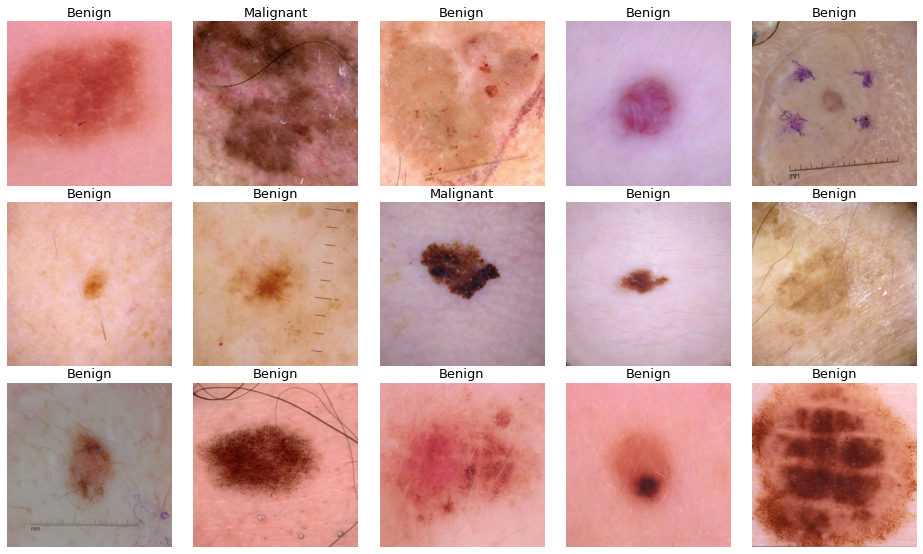

In [43]:
example_batch = iter(example_dataset) 
image_batch, label_batch = next(example_batch)
images = [(x) for x in image_batch]
labels = [l.numpy() for l in label_batch]
display_batch_of_images((images, labels), unbatched=True)

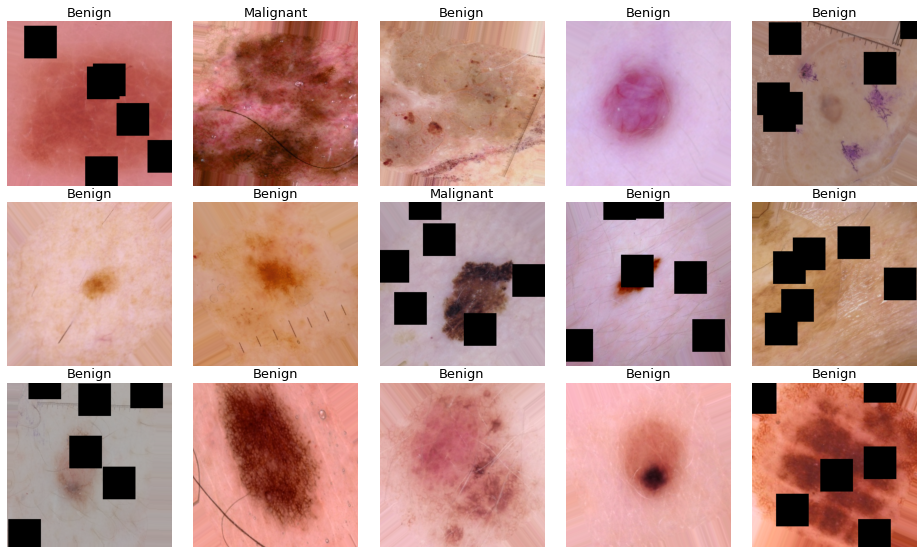

In [44]:
augmented_images = [augment_image(x, augment=True) for x in images]
augmented_images = [np.clip(x, 0, 1) for x in augmented_images]
labels = [l.numpy() for l in label_batch]
display_batch_of_images((augmented_images, labels), unbatched=True)

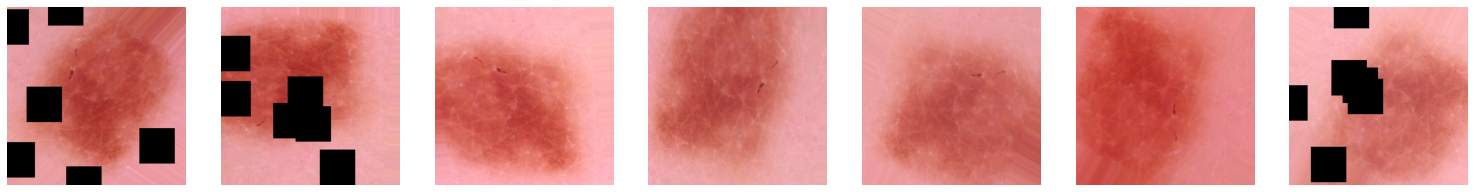

In [45]:
def plot_transform(num_images):
    plt.figure(figsize=(30,10))
    image = images[0]
    for i in range(1,num_images+1):
        plt.subplot(1,num_images+1,i)
        plt.axis('off')
        image_aug = augment_image(image)
        plt.imshow(np.clip(image_aug, 0, 1))

plot_transform(7)

In [46]:
for i in range(10):
    image = image_batch[i]
    print("min:", np.min(image), " -  max:", np.max(image))

print(image.dtype)

min: 0.08235294  -  max: 1.0
min: 0.0  -  max: 1.0
min: 0.08235294  -  max: 1.0
min: 0.16862746  -  max: 0.9058824
min: 0.027450982  -  max: 0.9215687
min: 0.08235294  -  max: 0.9843138
min: 0.019607844  -  max: 0.9450981
min: 0.011764707  -  max: 0.8000001
min: 0.13333334  -  max: 0.97647065
min: 0.058823533  -  max: 1.0
<dtype: 'float32'>


# Model Initialization

In [47]:
steps_per_epoch = TRAINING_IMAGES // BATCH_SIZE
validation_steps_per_epoch = VALIDATION_IMAGES // BATCH_SIZE

steps_per_execution = 5

training_dataset = get_training_dataset(augment=True)
validation_dataset = get_validation_dataset(repeat=True)

print("steps_per_epoch", steps_per_epoch)
print("validation_steps_per_epoch", validation_steps_per_epoch)
print("steps_per_execution", steps_per_execution)

steps_per_epoch 152
validation_steps_per_epoch 25
steps_per_execution 5


In [48]:
def get_model_parameters(steps_per_epoch, lr, epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
    ]

    return loss, metrics, optimizer


def compile_model(model):
    loss, metrics, optimizer = get_model_parameters(steps_per_epoch, LR_START, EPOCHS)
    if tpu:
        model.compile(
            loss=loss,
            metrics=metrics,
            optimizer=optimizer,
            # Reduce python overhead, and maximize the performance of your TPU
            # Anything between 2 and `steps_per_epoch` could help here.
            steps_per_execution=steps_per_execution,
        )
    else:
        model.compile(
            loss=loss,
            metrics=metrics,
            optimizer=optimizer,
        )

    return model

In [49]:
# Clear the session - this helps when we are creating multiple models
K.clear_session()

# Creating the model in the strategy scope places the model on the TPU
with strategy.scope():
    output_bias = None
    if initial_bias is not None:
        output_bias = tf.keras.initializers.Constant(initial_bias)

    base_model = efn.EfficientNetB5(
        include_top=False, 
        weights='imagenet', 
        input_shape=[DIM,DIM,3]
    )

    base_model.trainable = False
    
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid', bias_initializer=output_bias)
    ])
    model = compile_model(model)

model.summary()

115515392/115515256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 12, 12, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 28,529,921
Trainable params: 16,401
Non-trainable params: 28,513,520
_________________________________________________________________


# Initial Model Training

In [50]:
history = model.fit(
    training_dataset,
    epochs=3,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps_per_epoch,
    verbose=VERBOSE_LEVEL
)

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/3


COMET WARNING: auto_histogram_gradient_logging is True, but inputs and targets are not available; unable to log gradients
COMET WARNING: auto_histogram_activation_logging is True, but inputs are not available; unable to log activations


152/152 [==============================] - 148s 971ms/step - loss: 0.3614 - accuracy: 0.9300 - auc: 0.5050 - val_loss: 0.1779 - val_accuracy: 0.9819 - val_auc: 0.5929
Epoch 2/3
152/152 [==============================] - 60s 395ms/step - loss: 0.2757 - accuracy: 0.9411 - auc: 0.6710 - val_loss: 0.1784 - val_accuracy: 0.9819 - val_auc: 0.6508
Epoch 3/3
152/152 [==============================] - 61s 403ms/step - loss: 0.2695 - accuracy: 0.9410 - auc: 0.7292 - val_loss: 0.1784 - val_accuracy: 0.9819 - val_auc: 0.6962


# Full Training

In [51]:
K.clear_session()
with strategy.scope():
    # Make the whole model trainable
    base_model.trainable = True
    # We need to compile the model again after changing the layers
    model = compile_model(model)
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 12, 12, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 28,529,921
Trainable params: 28,357,185
Non-trainable params: 172,736
_________________________________________________________________


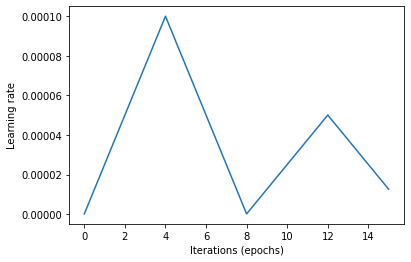

In [52]:
lr_callback = get_lr_callback(MODE, LR_MIN, LR_MAX, STEP_SIZE)
plot_clr(MODE, LR_MIN, LR_MAX, STEP_SIZE, EPOCHS)

In [53]:
callbacks = [lr_callback]

In [54]:
history = model.fit(
    training_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps_per_epoch,
    verbose=VERBOSE_LEVEL
)

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging


Epoch 1/16

Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000116860974e-07.
 25/152 [===>..........................] - ETA: 20:19 - loss: 0.4170 - accuracy: 0.9217 - auc: 0.4665WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 18.7813s vs `on_train_batch_end` time: 24.7503s). Check your callbacks.


152/152 [==============================] - 365s 2s/step - loss: 0.3832 - accuracy: 0.9306 - auc: 0.4689 - val_loss: 0.1769 - val_accuracy: 0.9819 - val_auc: 0.5033
Epoch 2/16

Epoch 00002: LearningRateScheduler reducing learning rate to 2.5074999939533882e-05.
152/152 [==============================] - 125s 820ms/step - loss: 0.3086 - accuracy: 0.9409 - auc: 0.5934 - val_loss: 0.1725 - val_accuracy: 0.9819 - val_auc: 0.7805
Epoch 3/16

Epoch 00003: LearningRateScheduler reducing learning rate to 5.004999911761843e-05.
152/152 [==============================] - 124s 819ms/step - loss: 0.2442 - accuracy: 0.9414 - auc: 0.8611 - val_loss: 0.1697 - val_accuracy: 0.9820 - val_auc: 0.8554
Epoch 4/16

Epoch 00004: LearningRateScheduler reducing learning rate to 7.502499647671357e-05.
152/152 [==============================] - 125s 821ms/step - loss: 0.2372 - accuracy: 0.9434 - auc: 0.8839 - val_loss: 0.1664 - val_accuracy: 0.9817 - val_auc: 0.8747
Epoch 5/16

Epoch 00005: LearningRateScheduler

In [55]:
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=VERBOSE_LEVEL,
    restore_best_weights=True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=VERBOSE_LEVEL)

callbacks = [lr_callback, earlyStopping]

In [56]:
history = model.fit(
    training_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps_per_epoch,
    verbose=VERBOSE_LEVEL
)

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging


Epoch 1/16
 25/152 [===>..........................] - ETA: 4:26 - loss: 0.2262 - accuracy: 0.9448 - auc: 0.9500WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0091s vs `on_train_batch_end` time: 5.8780s). Check your callbacks.


152/152 [==============================] - 158s 1s/step - loss: 0.2005 - accuracy: 0.9591 - auc: 0.9476 - val_loss: 0.1620 - val_accuracy: 0.9809 - val_auc: 0.9220
Epoch 2/16
152/152 [==============================] - 125s 823ms/step - loss: 0.1932 - accuracy: 0.9635 - auc: 0.9488 - val_loss: 0.1635 - val_accuracy: 0.9805 - val_auc: 0.9259

Epoch 00002: ReduceLROnPlateau reducing learning rate to 2.517499888199382e-06.
Epoch 3/16
152/152 [==============================] - 125s 821ms/step - loss: 0.1921 - accuracy: 0.9644 - auc: 0.9508 - val_loss: 0.1619 - val_accuracy: 0.9811 - val_auc: 0.9266

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.034999958297703e-07.
Epoch 4/16
152/152 [==============================] - 125s 820ms/step - loss: 0.1901 - accuracy: 0.9648 - auc: 0.9515 - val_loss: 0.1621 - val_accuracy: 0.9809 - val_auc: 0.9263

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0070000371342759e-07.
Epoch 5/16
152/152 [==============================] - 125s

In [57]:
model.save('model.h5')

# Model Evaluation

start predicting ...
Precision: 0.3064
Recall: 0.4569
Threshold: 0.229
F1 Score: 0.3668
              precision    recall  f1-score   support

      Benign       0.99      0.98      0.99      6420
   Malignant       0.31      0.46      0.37       116

    accuracy                           0.97      6536
   macro avg       0.65      0.72      0.68      6536
weighted avg       0.98      0.97      0.97      6536



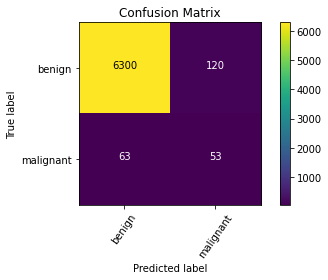

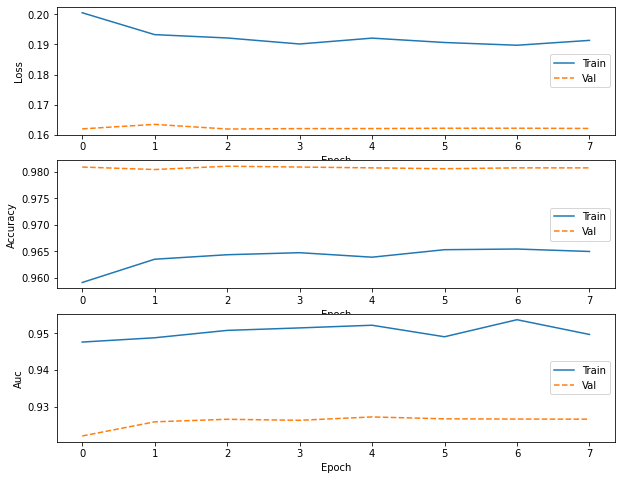

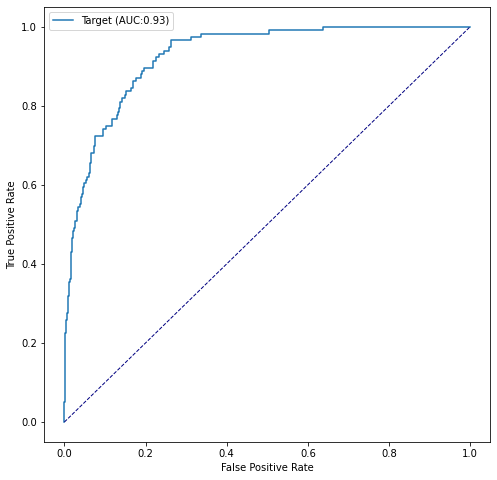

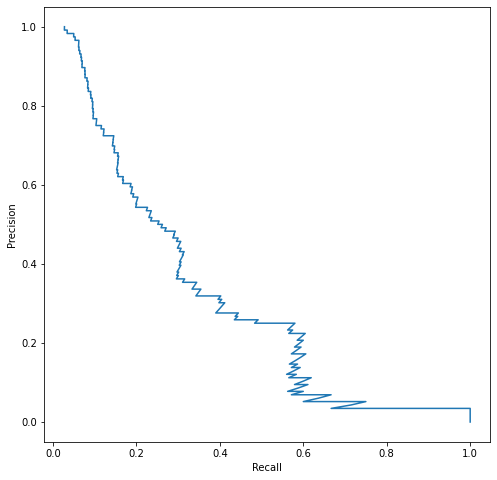

In [58]:
example_validation_dataset = get_validation_dataset(repeat=False)
predictions, labels, threshold = evaluate_model(
    model=model, 
    dataset=example_validation_dataset, 
    history=history,
    save_output=SAVE_OUTPUT, 
    timestamp=timestamp
)

# Stop Logging & Upload Results


In [59]:
with open("/content/metrics.txt") as json_file:
    metrics = json.load(json_file)
    experiment.log_metrics(metrics)

In [60]:
for f in glob.glob("/content/*.png"):
    name = f.split("-")[-1]
    experiment.log_image(f, name=name, overwrite=True, image_format="png")

In [61]:
experiment.log_model('model.h5', '/content/model.h5', overwrite=True)

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=36f6771b5b8046439d5361401faf2642&experimentKey=5f4da84d74c84b4bbc28ce5ce2804c2a',
 'assetId': '36f6771b5b8046439d5361401faf2642',
 'web': 'https://www.comet.ml/api/asset/download?assetId=36f6771b5b8046439d5361401faf2642&experimentKey=5f4da84d74c84b4bbc28ce5ce2804c2a'}

In [62]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/saschamet/master-thesis/5f4da84d74c84b4bbc28ce5ce2804c2a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [27]       : (0.9405325055122375, 0.9654605388641357)
COMET INFO:     auc [27]            : (0.47127005457878113, 0.9537266492843628)
COMET INFO:     batch_accuracy [27] : (0.9405325055122375, 0.9654605388641357)
COMET INFO:     batch_auc [27]      : (0.47127005457878113, 0.9537266492843628)
COMET INFO:     batch_loss [27]     : (0.18972748517990112, 0.3430764377117157)
COMET INFO:     epoch_duration [27] : (60.062443638999866, 365.18871722100016)
COMET INFO:     f1score             : 0.3668
COMET INFO:     loss [27]           : (0.18972748517990112, 0.3430764377117157)
COMET INFO:     lr [24]             : (8.056000311285061

# Kaggle Submission

In [63]:
test_dataset = get_test_dataset(ordered=True)
num_test_images = count_data_items(TEST_FILENAMES)

test_dataset_images = test_dataset.map(lambda image, image_name: image)
test_dataset_image_name = test_dataset.map(lambda image, image_name: image_name).unbatch()
test_ids = next(iter(test_dataset_image_name.batch(num_test_images))).numpy().astype('U')

In [64]:
predictions = model.predict(test_dataset_images, verbose=1, steps=math.ceil(len(test_ids) / BATCH_SIZE))

43/43 [==============================] - 37s 849ms/step


In [65]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(predictions)})
pred_df.head()

,image_name,target
0,ISIC_2272503,0.023643
1,ISIC_9821912,0.029035
2,ISIC_4347483,0.045585
3,ISIC_6645719,0.034820
4,ISIC_0456797,0.021482


In [66]:
pd.Series(np.round(pred_df['target'].values)).value_counts()

0.0    10856
1.0      126
dtype: int64

In [67]:
pred_df.to_csv("./submission.csv", index=False)
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "EffnetB5 Predictions"

100% 264k/264k [00:00<00:00, 312kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification